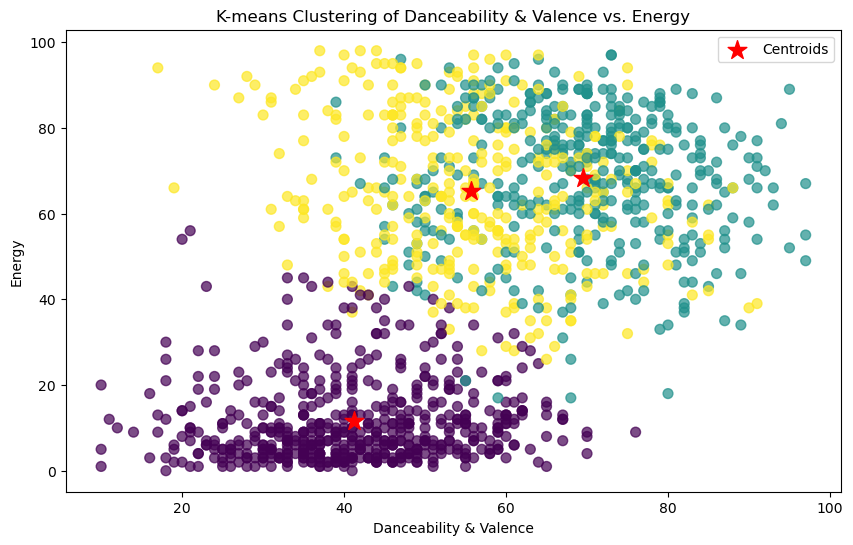

In [18]:
#Inspiration from model code and elbow plots came from GA lessons.

# Create my X.
X = spot[['dance', 'valence', 'energy']]

# Standardize the features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the number of clusters.
num_clusters = 3

# Create a K-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=12)

# Fit the model.
kmeans.fit(X_scaled)

# Get the centroids.
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Get cluster labels for each data point.
labels = kmeans.labels_

# Create a scatter plot of the data points.
plt.figure(figsize=(10, 6))
plt.scatter(X['dance'], X['energy'], c=labels, cmap='viridis', s=50, alpha=0.7)

# Plot the centroids as red stars.
plt.scatter(centroids[:, 0], centroids[:, 2], marker='*', c='red', s=200, label='Centroids')

# Labels.
plt.xlabel('Danceability & Valence')
plt.ylabel('Energy')
plt.title('K-means Clustering of Danceability & Valence vs. Energy')
plt.legend()
plt.show();

# Finding the best K value.

In [5]:
#Large intertia score so we may have too many clusters.
kmeans.inertia_

1338.8035979544034

In [6]:
# Create a list with different K values to see how the intertias will vary.
k_values = range(1,11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
inertias

[3864.0,
 1746.2140946363968,
 1338.8035979544034,
 1148.3790895853797,
 960.3820074837456,
 841.3199147425623,
 735.2815132556666,
 679.0544288560868,
 630.1938347420178,
 587.1612132313156]

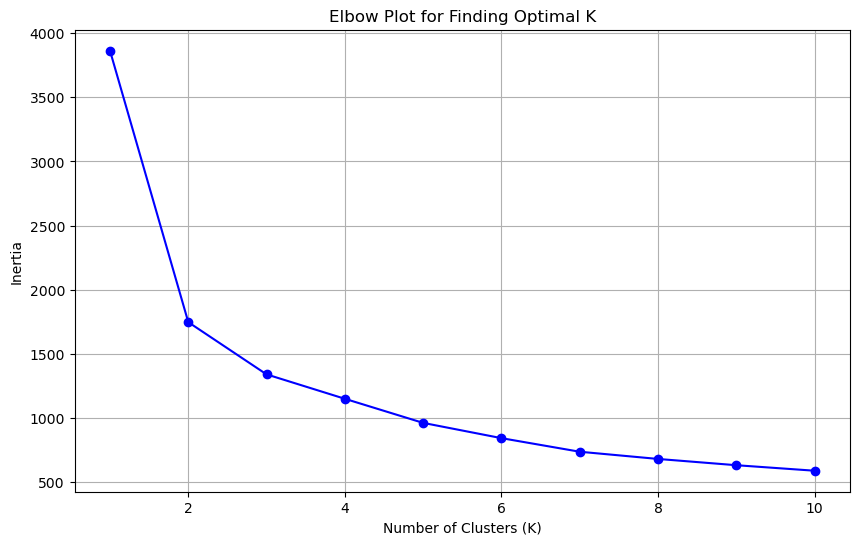

In [7]:
# Created the elbow plot to find the optimal k value via intertia scores.
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Finding Optimal K')
plt.grid(True)
plt.show()

From the elbow plot and the intertia list it is looking like 2 is the magic number.

In [8]:
# Not the highest silhouette score either so my clusters aren't very far apart from eachother.
silhouette_score(X_scaled, kmeans.labels_)

0.300318166437911

In [9]:
# Running different K values to see what the best silhouette score will be.

silhouette_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state = 12)
    kmeans.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, kmeans.labels_))
    
silhouette_list

[0.46621546871832575,
 0.3708330010410745,
 0.2997468288278237,
 0.29672149730154634,
 0.29273543016812226,
 0.3060133817845387,
 0.300129265362734,
 0.2912463432760309,
 0.300318166437911]

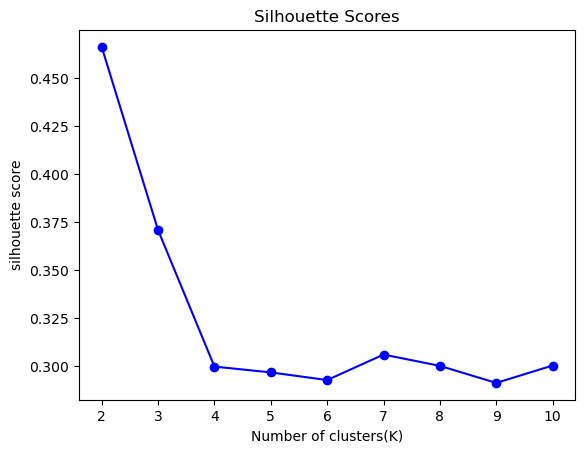

In [10]:
# Created an elbow plot for the silhouette scores.

plt.plot(range(2, 11), silhouette_list, marker = 'o', color = 'blue')
plt.xlabel('Number of clusters(K)')
plt.ylabel('silhouette score')
plt.title('Silhouette Scores');

Based off the scores and the chart the optimal value of k for silhouette scores is 2. 

## DBSCAN

In [11]:
# After adjusting epsilon values for a while it became very apparent that the clustering was not clearly separated in the dataset, so all models were poor.
dbscan = DBSCAN(eps = .39)
dbscan.fit(X_scaled)
pd.Series(dbscan.labels_).unique()

array([ 0, -1])

In [96]:
# DBSCAN silhouette score was only positive with 2 clusters after iteration and very bad.
silhouette_score(X_scaled, dbscan.labels_)

0.1414199146675286

In [13]:
# Created a column for the clusters to gather more insights.
spot['db cluster'] = dbscan.labels_

In [14]:
# Pretty much everything is 1 cluster.
spot['db cluster'].value_counts(normalize = True)

 0    0.953416
-1    0.046584
Name: db cluster, dtype: float64

In [15]:
# Separated the two clusters into dataframes to peer more into why there is a difference.
clust_0 = spot.loc[spot['db cluster'] == 0]
clust_1 = spot.loc[spot['db cluster'] == -1]

In [16]:
spot.groupby('db cluster').mean().T[[-1, 0]]

db cluster           -1            0
year        2015.133333  2016.858306
bpm          126.633333   116.965798
energy        55.133333    42.760586
dance         54.633333    53.733713
dB           -10.400000   -13.237785
live          19.566667    15.675081
valence       44.966667    39.105863
dur          196.050000   192.034202
acous         33.450000    53.890065
spch           9.450000     6.657166
popularity    55.966667    55.824919

+ Interestingly enough, the smaller cluster was comprised of faster bpm, higher energy , and less acoustic tendencies. This could be specifiying a genre like electro dance music who exhibit all of those qualities.

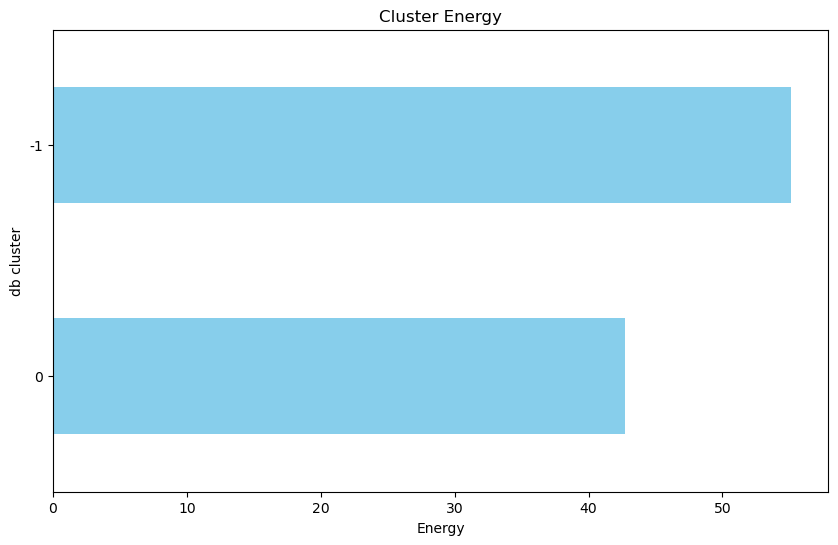

In [17]:
# Creating a horizontal bar plot to show the difference between energy in the two clusters.

cluster_mean_energy = spot.groupby('db cluster')['energy'].mean()

# Create a horizontal bar plot
ax = cluster_mean_energy.plot(kind='barh', figsize=(10, 6), color='skyblue')
ax.set_xlabel('Energy')
ax.set_title('Cluster Energy') 
ax.invert_yaxis()
plt.show();

## Recommender graveyard

## Lesson recommender

In [39]:
pivot = rec.pivot_table(values = 'km cluster', index = 'song title', columns = 'artist')

In [40]:
pivot.shape

(1288, 839)

In [41]:
pivot_sparse = sparse.csr_matrix(pivot.fillna(0))

In [43]:
distances = pairwise_distances(pivot_sparse, metric = 'cosine')

similarities = 1.0 - distances

In [44]:
similarities.shape

(1288, 1288)

In [45]:
pivot.index[:5]

Index(['(What A) Wonderful World', '2 Be Loved (Am I Ready)', '2 Much',
       '2step',
       '3 Concert Études, S. 144: No. 3 in D-Flat Major, "un sospiro"'],
      dtype='object', name='song title')

In [50]:
pivot.shape[:5]

(1288, 839)

In [46]:
recommender = pd.DataFrame(similarities, index = pivot.index, columns = pivot.index)

recommender.head()

song title                                          (What A) Wonderful World  \
song title                                                                     
(What A) Wonderful World                                                 1.0   
2 Be Loved (Am I Ready)                                                  0.0   
2 Much                                                                   0.0   
2step                                                                    0.0   
3 Concert Études, S. 144: No. 3 in D-Flat Major...                       0.0   

song title                                          2 Be Loved (Am I Ready)  \
song title                                                                    
(What A) Wonderful World                                                0.0   
2 Be Loved (Am I Ready)                                                 1.0   
2 Much                                                                  0.0   
2step                                                                   0.0   
3 Concert Études, S. 144: No. 3 in D-Flat Major...                      0.0   

song title                                          2 Much  2step  \
song title                                                          
(What A) Wonderful World                               0.0    0.0   
2 Be Loved (Am I Ready)                                0.0    0.0   
2 Much                                                 1.0    0.0   
2step                                                  0.0    1.0   
3 Concert Études, S. 144: No. 3 in D-Flat Major...     0.0    0.0   

song title                                          3 Concert Études, S. 144: No. 3 in D-Flat Major, "un sospiro"  \
song title                                                                                                          
(What A) Wonderful World                                                                          0.0               
2 Be Loved (Am I Ready)                                                                           0.0               
2 Much                                                                                            0.0               
2step                                                                                             0.0               
3 Concert Études, S. 144: No. 3 in D-Flat Major...                                                1.0               

song title                                          3 Nights  \
song title                                                     
(What A) Wonderful World                                 0.0   
2 Be Loved (Am I Ready)                                  0.0   
2 Much                                                   0.0   
2step                                                    0.0   
3 Concert Études, S. 144: No. 3 in D-Flat Major...       0.0   

song title                                          3 Nouvelles etudes, Op. posth.: II. Etude No. 26 in A-Flat Major  \
song title                                                                                                             
(What A) Wonderful World                                                                          0.0                  
2 Be Loved (Am I Ready)                                                                           0.0                  
2 Much                                                                                            0.0                  
2step                                                                                             0.0                  
3 Concert Études, S. 144: No. 3 in D-Flat Major...                                                0.0                  

song title                                          3 outfits  34+35  \
song title                                                             
(What A) Wonderful World                                  0.0    0.0   
2 Be Loved (Am I Ready)                                   0.0    0.0   
2 M

In [49]:
q = 'Save Your Tears'

for title in rec.loc[rec['song title'].str.contains(q), 'song title']:
    print(title)
    print(recommender[title].sort_values(ascending = False)[1:11])
    print()
    print()


Save Your Tears
song title
Blinding Lights                                                      1.0
Save Your Tears (with Ariana Grande) (Remix)                         1.0
Save Your Tears                                                      1.0
(What A) Wonderful World                                             0.0
Save Me                                                              0.0
Search & Rescue                                                      0.0
Scrapple From The Apple - Rudy Van Gelder Edition / 2003 Remaster    0.0
Scars To Your Beautiful                                              0.0
Scared To Live                                                       0.0
Say You Love Me                                                      0.0
Name: Save Your Tears, dtype: float64


Save Your Tears (with Ariana Grande) (Remix)
song title
Blinding Lights                                                      1.0
Save Your Tears (with Ariana Grande) (Remix)                         1.0
S

Well then.

## HELP

In [17]:
label_encoder = LabelEncoder()
rec['artist_encoded'] = label_encoder.fit_transform(rec['artist'])
rec['song_title_encoded'] = label_encoder.fit_transform(rec['song title'])

In [18]:
X = rec[['km cluster', 'artist_encoded', 'song_title_encoded']]

In [19]:
cosine_sim = cosine_similarity(X, X)

In [20]:
def get_recommendations(song_index, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[song_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]  # Exclude the first item (itself)
    song_indices = [x[0] for x in sim_scores]
    return rec.iloc[song_indices]

In [25]:
recommendations = get_recommendations(7)
print(recommendations)

                            artist  km cluster                song title  \
684                     Cecile Roy           1          Lost Frequencies   
687                 Boil The Ocean           1          I Still Miss You   
198              Garden Collective           1           phosphorescence   
654   Crosby, Stills, Nash & Young           1                 Our House   
62                     Chick Corea           0                    Matrix   
...                            ...         ...                       ...   
933                     Ed Sheeran           2                     2step   
968                     Tai Verdes           2                 3 outfits   
1073                 Justin Bieber           0                    2 Much   
910                          Lizzo           2   2 Be Loved (Am I Ready)   
659                      Sam Cooke           2  (What A) Wonderful World   

      artist_encoded  song_title_encoded  
684              137                 599  
6

## More cancer

In [55]:
cluster_0_songs = spot[spot['km cluster'] == 0]  # Replace 'cluster_label' with the actual column name
cluster_1_songs = spot[spot['km cluster'] == 1]  # Replace 'cluster_label' with the actual column name
cluster_2_songs = spot[spot['km cluster'] == 2]  # Replace 'cluster_label' with the actual column name

In [69]:
import string
import nltk
from nltk.tokenize import word_tokenize

# Define a function for text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    return tokens

# Apply text preprocessing to song titles in each cluster
cluster_0_songs['song tokens'] = cluster_0_songs['song title'].apply(preprocess_text)
cluster_1_songs['song tokens'] = cluster_1_songs['song title'].apply(preprocess_text)
cluster_2_songs['song tokens'] = cluster_2_songs['song title'].apply(preprocess_text)


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizers for each cluster
tfidf_vectorizer_0 = TfidfVectorizer()
tfidf_vectorizer_1 = TfidfVectorizer()
tfidf_vectorizer_2 = TfidfVectorizer()

# Fit and transform the song titles in each cluster
tfidf_matrix_0 = tfidf_vectorizer_0.fit_transform(cluster_0_songs['song_tokens'].apply(lambda x: ' '.join(x)))
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(cluster_1_songs['song_tokens'].apply(lambda x: ' '.join(x)))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(cluster_2_songs['song_tokens'].apply(lambda x: ' '.join(x)))


In [71]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrices for each cluster
cosine_sim_matrix_0 = cosine_similarity(tfidf_matrix_0)
cosine_sim_matrix_1 = cosine_similarity(tfidf_matrix_1)
cosine_sim_matrix_2 = cosine_similarity(tfidf_matrix_2)


In [84]:
def recommend_songs(song_title, cluster, cosine_sim_matrix, n=5):
    # Check if the song title exists in the cluster
    if song_title not in cluster['song title'].values:
        return "Song not found in this cluster."

    song_index = cluster[cluster['song title'] == song_title].index[0]
    sim_scores = list(enumerate(cosine_sim_matrix[song_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    song_indices = [i[0] for i in sim_scores]
    recommended_songs = cluster.iloc[song_indices]['song title']
    return recommended_songs


In [89]:
recommended_songs_cluster_0 = recommend_songs('chop suey', cluster_0_songs, cosine_sim_matrix_0)
recommended_songs_cluster_1 = recommend_songs('chop suey', cluster_1_songs, cosine_sim_matrix_1)
recommended_songs_cluster_2 = recommend_songs('chop suey', cluster_2_songs, cosine_sim_matrix_2)

In [93]:
def recommend_songs(song_title, cluster, cosine_sim_matrix, n=10):
    # Check if the song title exists in the cluster
    if song_title not in cluster['song title'].values:
        return "Song not found in this cluster."

    song_index = cluster[cluster['song title'] == song_title].index[0]
    sim_scores = list(enumerate(cosine_sim_matrix[song_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Get the top n (in this case, 10) similar songs
    song_indices = [i[0] for i in sim_scores]
    recommended_songs = cluster.iloc[song_indices]['song title']
    return recommended_songs

# Input the song title for which you want recommendations
input_song_title = 'RISE'

# Recommend the top 10 songs for the input song title in the correct cluster
if input_song_title in cluster_0_songs['song title'].values:
    recommended_songs = recommend_songs(input_song_title, cluster_0_songs, cosine_sim_matrix_0)
elif input_song_title in cluster_1_songs['song title'].values:
    recommended_songs = recommend_songs(input_song_title, cluster_1_songs, cosine_sim_matrix_1)
elif input_song_title in cluster_2_songs['song title'].values:
    recommended_songs = recommend_songs(input_song_title, cluster_2_songs, cosine_sim_matrix_2)
else:
    recommended_songs = "Song not found in any cluster."

# Print the top 10 recommended songs for the input song title
print("Top 10 recommended songs:")
print(recommended_songs)


Top 10 recommended songs:
1062                                         the breakup.
97                                The Bridge - Remastered
1071                                     The Hardest Part
113     The Surrey With The Fringe On Top - Remastered...
80                                         The Blues Walk
111                                      Moose The Mooche
1092                                      The Mess I Made
1054                          The Hardest Part - Acoustic
1091                                   You Are The Reason
1048                                   Writer In The Dark
Name: song title, dtype: object


In [86]:
cluster_0_songs.head()

song title           artist  \
49                                               RISE             YMIR   
53                                           Cherokee   Clifford Brown   
54                                Boogie Stop Shuffle   Charles Mingus   
55  Yes Or No - Rudy Van Gelder 24 Bit Mastering/1...    Wayne Shorter   
56         Leap Frog - Take 11 / Take 6 / Master Take  Dizzy Gillespie   

                top genre  year       added  bpm  energy  dance  dB  live  \
49            alternative  2022  1969‑12‑31  150      73     42  -5    36   
53                  bebop  1955  2023‑09‑01   87      66     43  -9     9   
54       avant-garde jazz  1959  2023‑09‑01  129      54     57 -12    30   
55  contemporary post-bop  1965  2023‑09‑01  129      68     47  -8     8   
56                  bebop  1952  2023‑09‑01   78      73     56  -9    35   

    valence  dur  acous  spch  popularity  km_cluster  km cluster  \
49       29  338      0     4          42           0           0   
53       64  344     42     5          43           0           0   
54       68  299     39     6          43           0           0   
55       48  399     71     4          43           0           0   
56       73  157     44    10          43           0           0   

                                          song_tokens  \
49                                             [rise]   
53                                         [cherokee]   
54                            [boogie, stop, shuffle]   
55  [yes, or, no, rudy, van, gelder, 24, bit, mast...   
56      [leap, frog, take, 11, take, 6, master, take]   

                                          song tokens  
49                                             [rise]  
53                                         [cherokee]  
54                            [boogie, stop, shuffle]  
55  [yes, or, no, -, rudy, van, gelder, 24, bit, m...  
56  [leap, frog, -, take, 11, /, take, 6, /, maste...

In [87]:
cluster_1_songs.head()

song title         artist    top genre  year  \
50   Giant Steps - 2020 Remaster  John Coltrane        bebop  2020   
52                          Move    Miles Davis    cool jazz  1957   
59   Without a Song - Remastered  Sonny Rollins        bebop  1962   
115               So Far So Good    Sun Of They  alternative  2022   
116                     Apricity      Imala Zir  alternative  2022   

          added  bpm  energy  dance  dB  live  valence  dur  acous  spch  \
50   2023‑09‑01  147      42     42 -13    19       52  288     19     6   
52   2023‑09‑01  136      41     50 -12    12       84  154     75     7   
59   2023‑09‑01  112      28     61 -16    14       34  447     75     5   
115  2023‑09‑08   74       7     58 -23    11       24  152     98     3   
116  2023‑09‑08   75      24     47 -23    12        5  158     84     3   

     popularity  km_cluster  km cluster                     song_tokens  \
50           57           1           1  [giant, steps, 2020, remaster]   
52           48           1           1                          [move]   
59           41           1           1  [without, a, song, remastered]   
115          65           1           1             [so, far, so, good]   
116          64           1           1                      [apricity]   

                           song tokens  
50   [giant, steps, -, 2020, remaster]  
52                              [move]  
59   [without, a, song, -, remastered]  
115                [so, far, so, good]  
116                         [apricity]

In [88]:
cluster_2_songs.head()

song title              artist           top genre  year  \
0            Chop Suey!    System Of A Down   alternative metal  2001   
1          Just Pretend           Bad Omens  american metalcore  2022   
2               Monster             Skillet   alternative metal  2009   
3       Popular Monster  Falling In Reverse   alternative metal  2019   
4  Watch The World Burn  Falling In Reverse   alternative metal  2023   

        added  bpm  energy  dance  dB  live  valence  dur  acous  spch  \
0  1969‑12‑31  127      93     42  -4    13       29  210      0    12   
1  1969‑12‑31  140      83     46  -5    10       20  205      0     8   
2  1969‑12‑31  135      96     64  -2     8       69  178      4     7   
3  1969‑12‑31  165      90     46  -4    10       36  221      1     9   
4  1969‑12‑31  162      78     40  -6    21       35  204      1    13   

   popularity  km_cluster  km cluster                song_tokens  \
0          86           2           2               [chop, suey]   
1          81           2           2            [just, pretend]   
2          80           2           2                  [monster]   
3          78           2           2         [popular, monster]   
4          78           2           2  [watch, the, world, burn]   

                 song tokens  
0            [chop, suey, !]  
1            [just, pretend]  
2                  [monster]  
3         [popular, monster]  
4  [watch, the, world, burn]

## Recommender Using Energy. 

In [7]:
# Recommender function for energy.
def recommend_songs_by_energy(input_energy, num_recommendations=10):
    rec['energy_difference'] = np.abs(rec['energy'] - input_energy)
    rec_sorted = rec.sort_values('energy_difference')
    top_recommendations = rec_sorted.head(num_recommendations)
    return top_recommendations

# User input for energy.
input_energy = float(input("Please enter how energetic you are feeling(between 1 and 100): "))

# Get song recommendations based on the input energy value
recommendations = recommend_songs_by_energy(input_energy)

# Display the top recommended songs
print(f"Top {len(recommendations)} Here is your playlist for your current energy level, {input_energy}:")
print(recommendations[['song title', 'artist', 'energy']])

Please enter how energetic you are feeling(between 1 and 100):  70


Top 10 Here is your playlist for your current energy level, 70.0:
                                             song title         artist  energy
1172                                             MAMIII        Becky G      70
532                                         My Universe       Coldplay      70
1256                                              JOKER            Dax      70
392                                        Cruel Summer   Taylor Swift      70
425                                            AMARGURA        KAROL G      70
543                            Kiss Me More (feat. SZA)       Doja Cat      70
550                              Astronaut In The Ocean    Masked Wolf      70
1243                                         YuNg BrAtZ   XXXTENTACION      70
1132                                     You & Jennifer          bülow      70
70    Locomotion - Remastered 2003/Rudy Van Gelder E...  John Coltrane      70
